<img src="https://drive.google.com/uc?id=1-d7H1l1lJ28_sLcd9Vvh_N-yro7CJZcZ" style="Width:1000px">

# Seismic event in California: Earthquake or not?

In this data problem, you will try to train the best algorithm to detect man-made seismic event (a "quake") in California. We will use this as an opportunity to try out the two new `MLPClassifer`, as well as `tuning` your algorithm. I am giving you the California Earthquakes dataset, with most columns still in. It is your decision what to do with the data (this is a data problem so close to what I would expect for your marked coursework). If you need more details about what the [columns names and what they mean you can be gather it from the USGS](https://earthquake.usgs.gov/data/comcat/data-eventterms.php).

For test consistency, **always use `random_state=42`** when you need a random state!



## My solutions

In [1]:
#importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn import set_config
set_config(display='diagram')

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


# understanding the problem
from the question it is obvious we need to do binary classification: `earthquake` and `not earthquake` 

In [2]:
df = pd.read_csv('input/raw_data/training_data.csv')
df

,type,time,mag,place,status,tsunami,sig,net,nst,dmin,rms,gap,magType,longitude,latitude,depth
0,earthquake,49:51.4,2.43,"7km NNE of Imperial, CA",reviewed,0,91,ci,21.0,0.08845,0.3500,129.00,ml,-115.531000,32.899833,10.000
1,earthquake,04:49.7,2.57,"14km SSE of Puebla, B.C., MX",reviewed,0,102,ci,23.0,0.37510,0.3900,202.00,ml,-115.309833,32.447500,6.006
2,earthquake,00:44.4,2.64,"Long Valley area, California",reviewed,0,107,nc,23.0,0.01712,0.0600,106.00,md,-118.846833,37.592167,7.145
3,earthquake,54:35.9,2.14,"33km ENE of Ensenada, B.C., MX",reviewed,0,70,ci,13.0,0.67530,0.2200,288.00,mh,-116.296333,31.991667,6.000
4,earthquake,03:03.7,2.99,"64km E of Maneadero, Mexico",reviewed,0,138,ci,21.0,0.24100,0.1400,158.00,ml,-115.886500,31.768833,17.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282002,earthquake,15:39.9,2.16,offshore Northern California,reviewed,0,72,nc,11.0,0.14410,0.0700,264.00,md,-124.458333,40.364667,6.479
282003,earthquake,54:22.3,2.10,Nevada,reviewed,0,68,nn,7.0,0.01400,0.1125,176.15,mb,-118.578300,38.068300,0.000
282004,earthquake,32:34.8,2.31,"26km E of Coso Junction, California",reviewed,0,82,ci,0.0,NaN,0.1650,231.20,mc,-117.666000,36.079000,0.632
282005,earthquake,35:06.6,2.40,Oregon,reviewed,0,89,uw,8.0,0.68090,0.4500,284.00,md,-122.092000,42.363000,10.120


In [3]:
df['type'].unique()

array(['earthquake', 'explosion', 'quarry blast', 'nuclear explosion',
       'rock burst', 'other event', 'mining explosion', 'sonic boom',
       'chemical explosion', 'mine collapse', 'acoustic noise',
       'Rock Slide', 'quarry', 'not reported', 'landslide'], dtype=object)

In [4]:
df['target'] = df['type'] != 'earthquake'

## duplicates - split

In [5]:
df.duplicated().sum()

1

In [6]:
df.drop_duplicates(inplace=True)

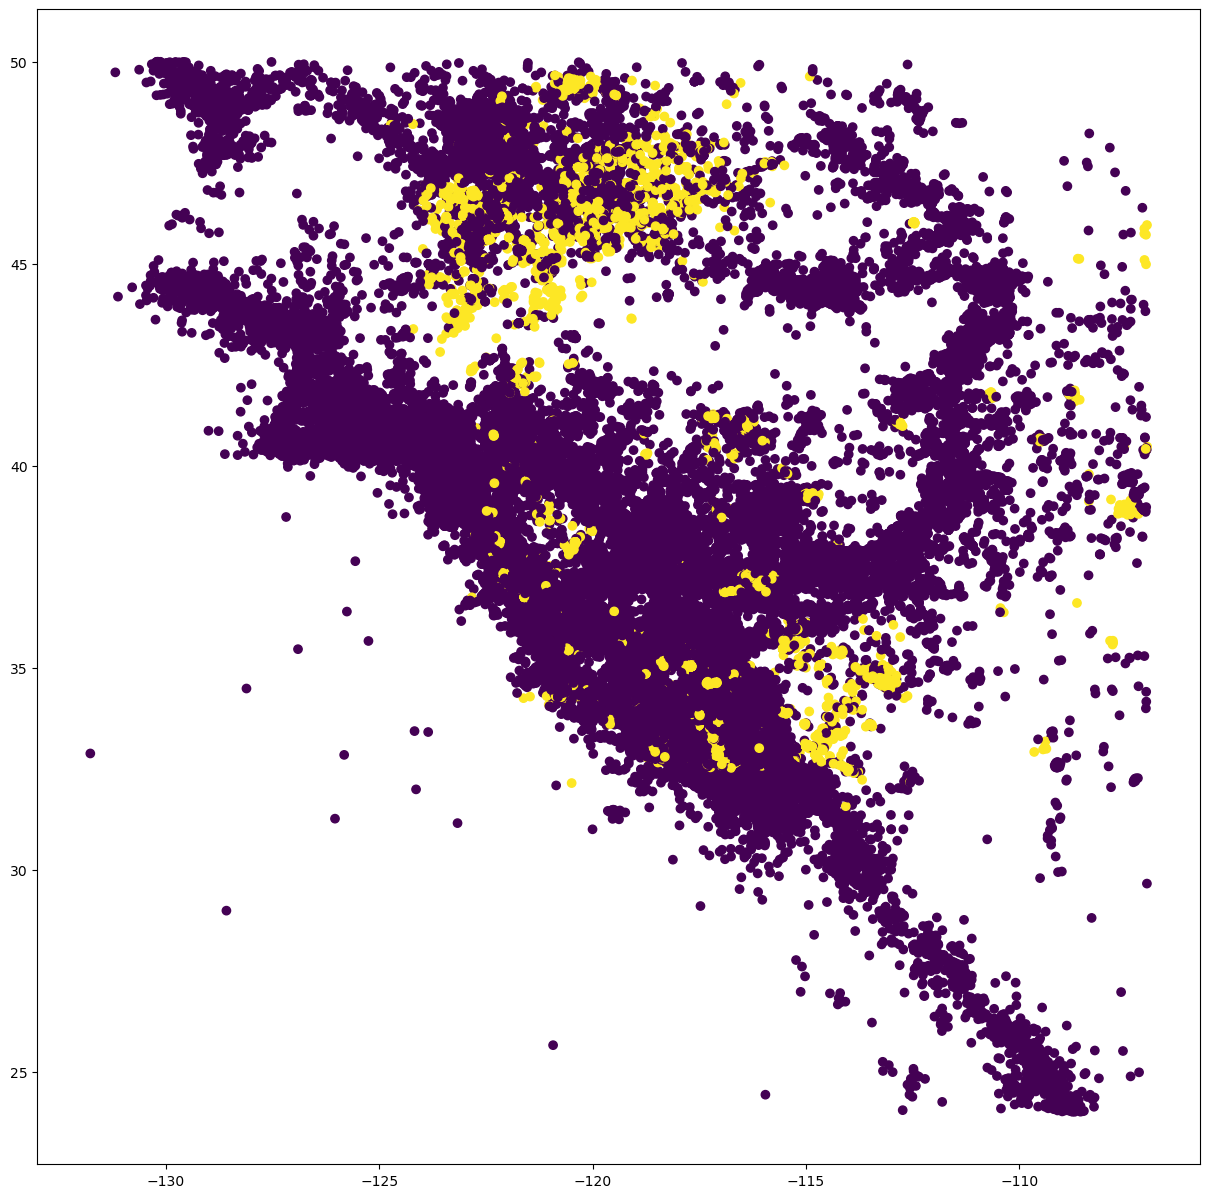

In [7]:
plt.figure(figsize=(15,15))
plt.scatter(df['longitude'],df['latitude'], c=df['target'])


In [8]:
#Note1: splitt the data geographically and wise
y = df['target']
X = df.drop(columns=['target','type'])
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8,random_state=42 )

In [10]:
# test_data = df[(df['latitude'] >= 42) & (df['latitude'] <= 46)]
# train_data = df[(df['latitude'] < 42) | (df['latitude'] > 46)]


# EDA for selecting best features
this includes deep understanding our features and colinearity among them

In [9]:
X_train.dtypes

time          object
mag          float64
place         object
status        object
tsunami        int64
sig            int64
net           object
nst          float64
dmin         float64
rms          float64
gap          float64
magType       object
longitude    float64
latitude     float64
depth        float64
dtype: object

In [10]:
num_data = X_train.select_dtypes(include=['int64','float64']).columns

cat_data = X_train.select_dtypes(include=['object']).columns

In [13]:
cat_data

Index(['time', 'place', 'status', 'net', 'magType'], dtype='object')

In [14]:
X_train[cat_data]['magType'].value_counts()

md       88735
ml       71946
mc       46722
mh       12945
mb        2760
mw        1313
mwr        278
ma         190
mlr        186
Md         150
mwc        143
mww         76
Ml          60
ms          59
mwb         18
mdl          8
mun          8
mblg         2
mb_lg        1
ms_20        1
Name: magType, dtype: int64

In [16]:
X_train[cat_data]
# Note use featurehashing and keep magType

,time,place,status,net,magType
198812,56:40.2,Nevada,reviewed,nn,ml
42868,13:58.1,"28km SSW of Ludlow, CA",reviewed,ci,ml
81676,23:44.0,"18km W of Westmorland, CA",reviewed,ci,mc
96292,58:49.9,"1km ENE of Pacheco, California",reviewed,nc,md
263859,20:22.9,"30km WSW of Hawthorne, Nevada",reviewed,nn,ml
...,...,...,...,...,...
119880,44:57.9,Northern California,reviewed,nc,md
259179,31:27.3,Washington,reviewed,uw,md
131933,06:15.4,"7km S of Yucca Valley, CA",reviewed,ci,md
146868,43:39.9,"34km N of Yucca Valley, California",reviewed,ci,mc


In [17]:
cat_data = cat_data.drop(['time', 'place', 'status', 'magType'])

In [18]:
num_data

Index(['mag', 'tsunami', 'sig', 'nst', 'dmin', 'rms', 'gap', 'longitude',
       'latitude', 'depth'],
      dtype='object')

In [19]:
num_data = num_data.drop(['longitude', 'latitude', 'tsunami'])

In [20]:
X_train['tsunami'] = X_train['tsunami'].astype(bool)


In [21]:
cat_data = cat_data.tolist()
cat_data.append('tsunami')

In [23]:
num_data

Index(['mag', 'sig', 'nst', 'dmin', 'rms', 'gap', 'depth'], dtype='object')

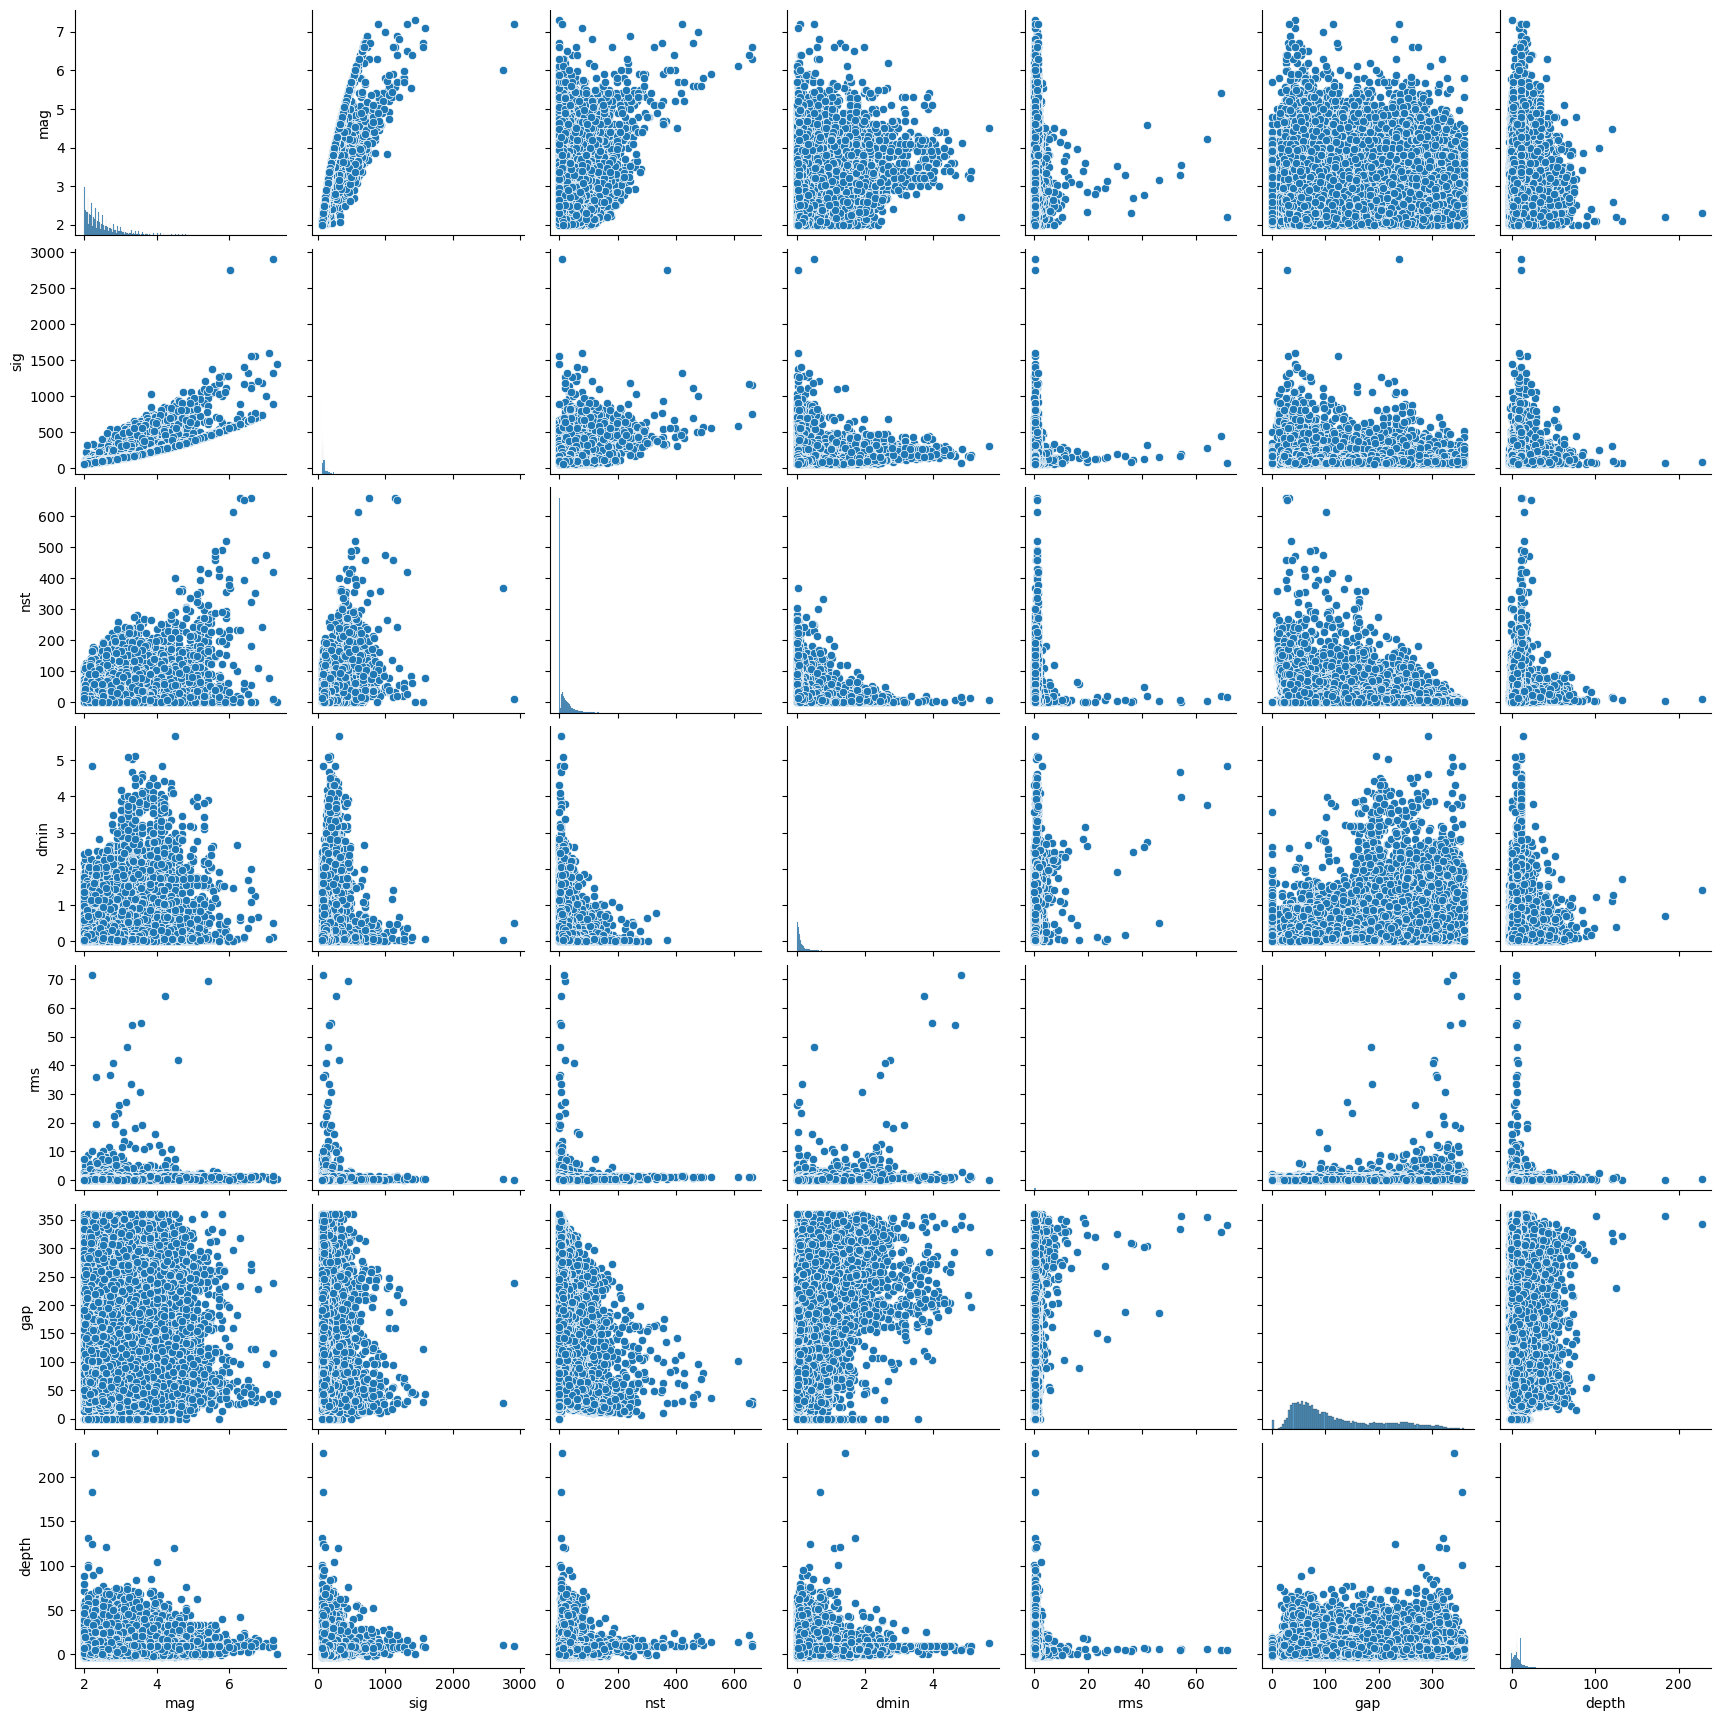

In [20]:
sns.pairplot(X_train[num_data]);

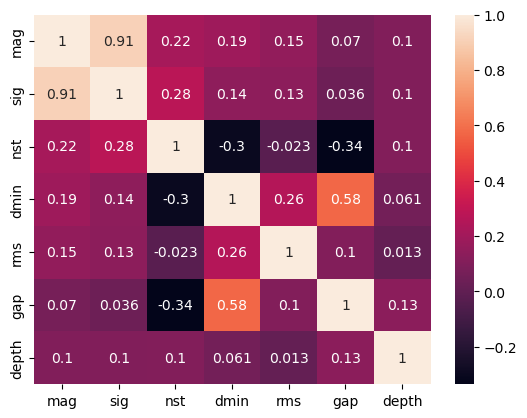

In [24]:
corr = X_train[num_data].corr()
sns.heatmap(corr, annot=corr);

In [25]:
num_data = num_data.drop('sig')

In [26]:
cat_data

['net', 'tsunami']

In [27]:
num_data

Index(['mag', 'nst', 'dmin', 'rms', 'gap', 'depth'], dtype='object')

In [25]:
# NOTE3: dmin, mag, and gap can be transform to log

# X_train_logtransformed = X_train[num_data].copy()
# X_train_logtransformed[X_train_logtransformed <= 0] = 0.01

# X_train_logtransformed = np.log(X_train_logtransformed)

# skew_threshold = 0.75
# skewed_features = X_train[num_data].apply(lambda x: x.skew()).sort_values(ascending=False)
# highly_skewed = skewed_features[skewed_features > skew_threshold].index

# X_train_transformed = X_train.copy()
# for feature in highly_skewed:
#     X_train_transformed[feature] = X_train_transformed[feature].apply(lambda x: np.log(x + 1) if x > 0 else 0)


# Outliers Scaling and Missings

In [28]:
X_train[num_data].describe()

,mag,nst,dmin,rms,gap,depth
count,225604.000000,218689.000000,163226.000000,223105.000000,221093.000000,225600.000000
mean,2.503949,20.515357,0.198303,0.197736,120.896811,6.283907
std,0.510523,23.955350,0.297159,0.454591,82.331939,6.228916
min,2.000000,0.000000,0.000000,0.000000,0.000000,-3.500000
25%,2.140000,0.000000,0.038740,0.080000,57.000000,2.225750
50%,2.350000,14.000000,0.089190,0.150000,92.000000,5.389000
75%,2.700000,30.000000,0.224000,0.230000,174.400000,8.787250
max,7.300000,659.000000,5.654000,71.450000,360.000000,227.400000


In [27]:
X_train = X_train[X_train['rms'] < 10]
X_train = X_train[X_train['depth'] > 0]


In [29]:
num_pipe = make_pipeline(SimpleImputer(), StandardScaler())
cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))

In [30]:
final_pipe = ColumnTransformer([
    ('num', num_pipe, num_data),
    ('cat', cat_pipe, cat_data)])

In [31]:
final_pipe

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['mag', 'nst', 'dmin', 'rms', 'gap', 'depth'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['net', 'tsunami'])])

In [32]:
y_train.value_counts()

False    211026
True      14578
Name: target, dtype: int64

- oversampling the smaller class (ex. SMOTE), undersampling the bigger class:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

final_pipe = ImbPipeline([
    ('preprocessing', full_pipeline),
    ('sampling', SMOTE()),
    ('classifier', MLPClassifier(max_iter=100))
])

- class_weight parameter to 'balanced' :
final_pipe = make_pipeline(
    full_pipeline, 
    MLPClassifier(max_iter=100, class_weight='balanced')
)

- Ensemble methods, like Random Forests or Gradient Boosting
- Use evaluation metrics that are informative for imbalanced datasets, such as Precision, Recall, F1-score, or the Area Under the Receiver Operating Characteristic Curve (ROC AUC), instead of accuracy
-

In [33]:
final_pipe2 = make_pipeline(final_pipe, MLPClassifier(max_iter=20))

In [34]:
final_pipe2

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['mag', 'nst', 'dmin', 'rms', 'gap', 'depth'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['net', 'tsunami'])])),
                ('mlpclassifier', MLPClassifier(max_iter=20))])

In [35]:
grid = {
    'mlpclassifier__hidden_layer_sizes':[(100,100), (200,100,50)],
    'mlpclassifier__alpha':[0.0001,0.01]
    
}

mlp_gridsearch = GridSearchCV(final_pipe2, param_grid=grid, 
                      cv=5, n_jobs=-1, scoring='precision')

In [36]:
mlp_gridsearch.fit(X_train, y_train)

/home/parastoo08/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/parastoo08/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/parastoo08/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/parastoo08/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warning

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['mag', 'nst', 'dmin', 'rms', 'gap', 'depth'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['net',
                                                                          'tsunami'])])),
                                       ('mlpclassifier',
                                        MLPClassifier(max_iter=20))]),
             n_jobs=-1,
             param_grid={'mlpclassifier__alpha': [0.0001, 0.01],
                         'mlpclassifier__hidden_layer_sizes': [(100, 100),
                                                               (200, 100, 50)]},
             scoring='precision')

In [61]:
mlp_gridsearch_score = mlp_gridsearch.best_score_
mlp_gridsearch_score

0.7906232722538624

In [62]:
imbalancedmodel =  mlp_gridsearch.best_estimator_


In [63]:
from sklearn.metrics import precision_score
estimated_precision = precision_score(y_test, imbalancedmodel.predict(X_test))
estimated_precision

0.7841094106154347

More epoch!


**Conclusion:** This is a pretty good score. Now we can make the predictions on the `seismic_events.csv` file.

# Making the predictions on new samples and saving

In [ ]:
new_events = pd.read_csv('raw_data/seismic_events.csv')

In [ ]:
y_pred = pd.Series(imbalancedmodel.predict(new_events), name='y_pred')
y_pred

In [ ]:
y_pred.to_csv('predictions.csv', index=False) # If we don't use index=False, the index will be saved in the file as a feature...